## NEURAL NETWORKS AND DEEP LEARNING <br> PHYSICS OF DATA - Department of Physics and Astronomy  <br>  A.A. 2019/20 (6 CFU) <br> Student: Matteo Guida


## DASET

True label is 6


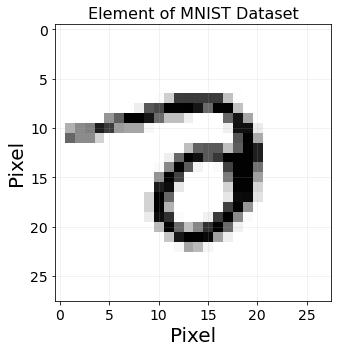

In [1]:
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import warnings
import scipy.io as sio
import torch.optim as optim
import torch
import pickle
import torch.nn as nn
from FFNN_Pytorch import NN_model,get_list_rand_search
import torch
import time

warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load the MNIST dataset.
data = sio.loadmat('MNIST.mat')
numbers = data['output_labels']
images = data['input_images']

# Shuffle the dataset.
np.random.seed(8)
randomize = np.arange(numbers.shape[0])
np.random.shuffle(randomize)
images = images[randomize]
numbers = numbers[randomize]

# Plot one digit and its label as an example.
item = 1
print('True label is', int(numbers[item]))
fig = plt.figure()
plt.imshow(np.reshape(images[item], (28, 28)), cmap='Greys')
plt.title('Element of MNIST Dataset',fontsize=16)
plt.xlabel("Pixel",fontsize=20)
plt.ylabel("Pixel",fontsize=20)
plt.tick_params(labelsize=14)
fig.set_size_inches(7, 5)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('./plots/mnist_sample.png',bbox_inches="tight")
plt.show()

In [2]:
# Divide the whole dataset in 10% test set and 90% training set.
TRAIN_PERCENTAGE = 0.90

X_train = torch.Tensor(images[ : int(TRAIN_PERCENTAGE*len(images))])
X_test  = torch.Tensor(images[int(TRAIN_PERCENTAGE*len(images)) :  ])

# squeeze() remove single-dimensional entries from the shape of an array.
y_train = torch.LongTensor(numbers[ : int(TRAIN_PERCENTAGE*len(numbers))]).squeeze()
y_test  = torch.LongTensor(numbers[int(TRAIN_PERCENTAGE*len(numbers)) : ]).squeeze()

## RANDOM SEARCH

In [3]:
# Parameter for random search. 
params_dict = {
           "neurons_architecture":[50,600],
           "activation":  [nn.LeakyReLU(),nn.ReLU(),nn.Hardswish()],
           "lr" : [-3,-2],
           "penalty" : [-4,-2],
           "optimizer" : ['torch.optim.Adam', 'torch.optim.Adamax'],
           "dropout" : [0.3,0.5],          
           "ncombinations" : [200],
           "n_epochs" : [int(2e3)]
           }


In [4]:
# The list with ncombinations of the values for the hyperparameters extracet according to the priors is created. 
list_single_dict= get_list_rand_search(params_dict=params_dict)

## SELECTED MODEL CLASS FINAL TRAINING

In [5]:
with open('train_results.data', "rb") as input_file:
    load_results = pickle.load(input_file)
load_results = list(zip(*load_results))
best_combination = load_results[0][5]
print("AVERAGE VALIDATION ERROR BEST HP:", round(load_results[0][0],3), " ± ", round(load_results[0][1],3) )
print("")
print("BEST FOUND HP CLASS: \n",best_combination)

AVERAGE VALIDATION ERROR BEST HP: 99.986  ±  0.003

BEST FOUND HP CLASS: 
 {'neurons_architecture': matrix([[784, 249,  36,  10]]), 'activation': [ReLU()], 'optimizer': ['torch.optim.Adam'], 'dropout': [0.3472158824647671], 'lr': [0.005414063118999791], 'penalty': [0.00012308325103055866], 'n_epochs': [2000]}


In [6]:
best_network = NN_model(best_combination).to(device)

In [7]:
train_loss_log,test_loss_log,test_accuracy_log,train_loss,val_loss,train_loss, validat_loss = best_network.trainin(data_train=X_train, 
                    label_train=y_train,data_val=X_test, label_val=y_test,params_dict=best_combination,return_log=True,save_model=True)

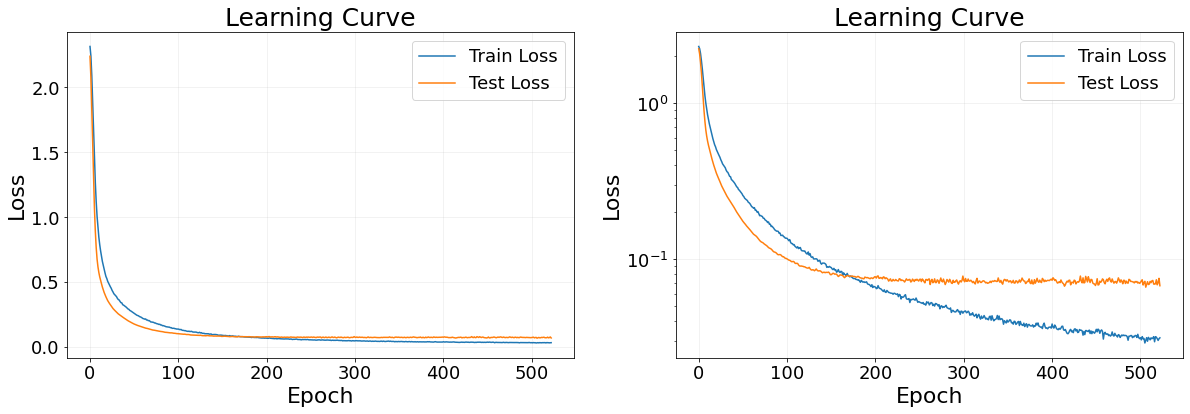

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(train_loss_log, label='Train Loss')
ax[0].plot(test_loss_log, label='Test Loss')
ax[0].set_ylabel("Loss",fontsize=22)
ax[0].set_xlabel("Epoch",fontsize=22)
ax[0].set_title('Learning Curve',fontsize=25)
ax[0].tick_params(labelsize=18)
ax[0].legend(fontsize=18)
ax[0].grid(alpha=0.2)

ax[1].plot(train_loss_log, label='Train Loss')
ax[1].plot(test_loss_log, label='Test Loss')
ax[1].set_ylabel("Loss",fontsize=22)
ax[1].set_xlabel("Epoch",fontsize=22)
ax[1].set_title('Learning Curve',fontsize=25)
ax[1].tick_params(labelsize=18)
ax[1].legend(fontsize=18)
ax[1].set_yscale('log')
ax[1].grid(alpha=0.2)

plt.savefig('./plots/learning_curve.png',bbox_inches="tight")

plt.show()

In [9]:
loaded_net = torch.load('best_network.dat')
accuracy = loaded_net.accuracy(x_test=X_test,y_test=y_test)
print("ACCURACY BEST HP ON TEST SET :", round(accuracy,2), "%")

ACCURACY BEST HP ON TEST SET : 98.12 %


## VISUALIZATION FEATURE ENCODED BY LAST LAYER NEURONS

In [10]:
W1=loaded_net.fc1.weight.cpu().detach().numpy()
W2=loaded_net.fc2.weight.cpu().detach().numpy()
W3=loaded_net.fc3.weight.cpu().detach().numpy()

In [11]:
# Perceptive field computation.
perceptive_field_last_layer = W3 @ W2 @ W1
perceptive_field_last_layer.shape

(10, 784)

In [12]:
# Implementation of gradient ascent over the images pixels.
list_image = []
np.random.seed(21)
for i in range(10):
    # Start with image composed by pixels randomly initialized. 
    random_image = torch.tensor(np.random.rand(1,784), requires_grad=True,dtype=torch.float).to(device)
    for _ in range(3000):
        random_image = Variable(random_image, requires_grad=True)
        net_output = loaded_net.forward(random_image)
        neuron_output = net_output[0,i]
        # backpropagation of the gradient to update pixel values.
        neuron_output.backward()
        # gradient ascent updating of the starting random image.
        updated_im = random_image + 0.01*random_image.grad 
        random_image = updated_im.detach()
    # list of images related to each neuron of the last layer.
    list_image.append(updated_im.detach().cpu())

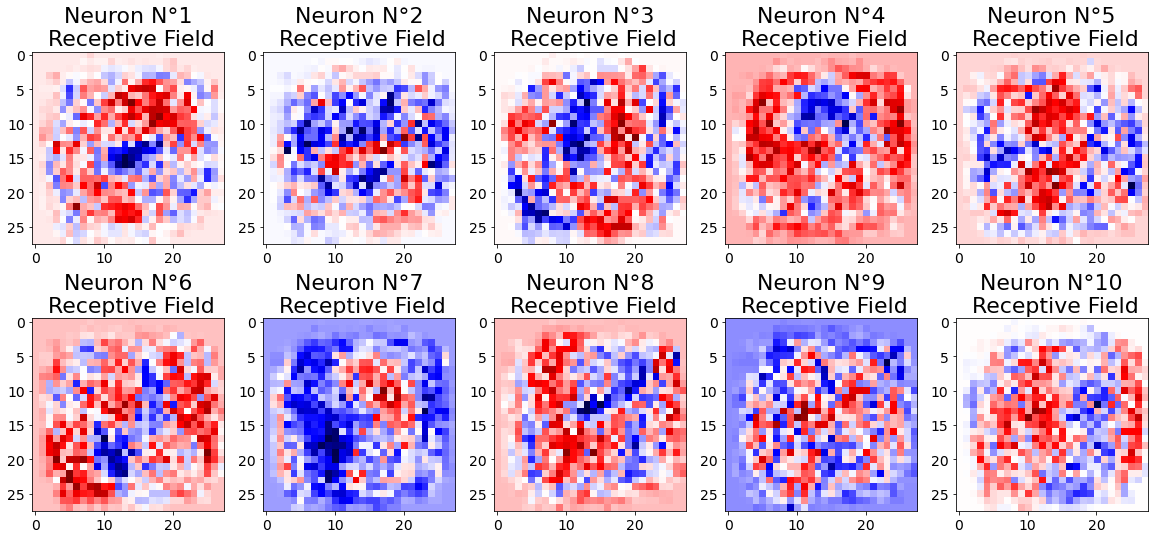

In [13]:
fig, ax = plt.subplots(2,5, figsize=(20,9))

for i in range(5):

    ax[0][i].imshow(perceptive_field_last_layer[i].reshape(28,28), cmap='seismic')
    ax[0][i].set_title('Neuron N°'+str(i+1)+"\n Receptive Field",fontsize=22)
    ax[0][i].tick_params(labelsize=14)


    ax[1][i].imshow(perceptive_field_last_layer[5+i].reshape(28,28), cmap='seismic')
    ax[1][i].set_title('Neuron N°'+str(i+6)+"\n Receptive Field",fontsize=22)
    ax[1][i].tick_params(labelsize=14)

plt.savefig('./plots/receptive_field.png',bbox_inches="tight")
plt.show()

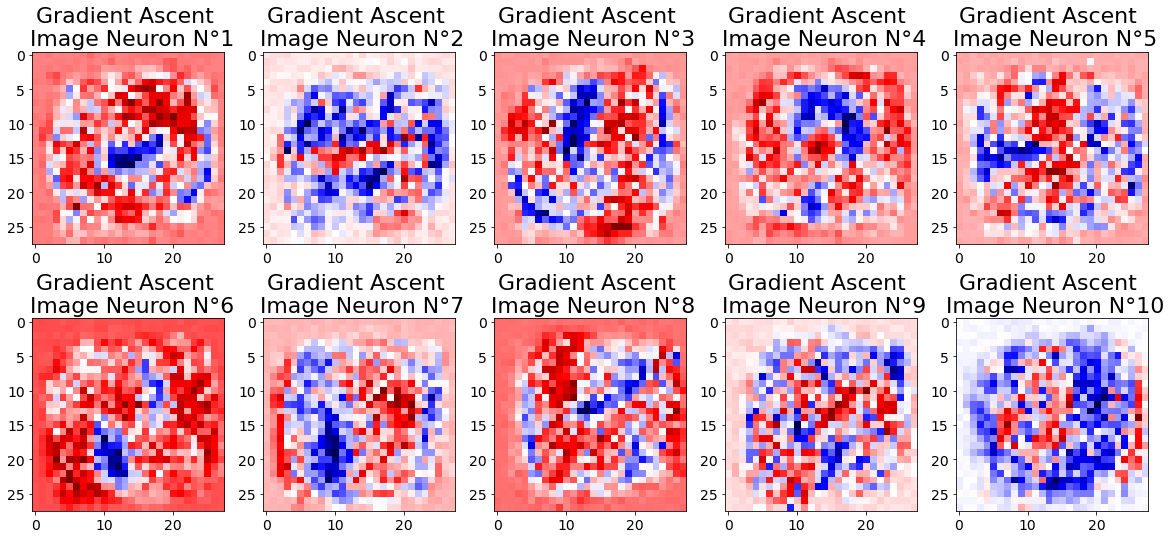

In [14]:
fig, ax = plt.subplots(2,5, figsize=(20,9))

for i in range(5):

    ax[0][i].imshow(list_image[i].reshape(28,28), cmap='seismic')
    ax[0][i].set_title("Gradient Ascent \n Image"+' Neuron N°'+str(i+1),fontsize=22)
    ax[0][i].tick_params(labelsize=14)

    ax[1][i].imshow(list_image[5+i].reshape(28,28), cmap='seismic')
    ax[1][i].set_title("Gradient Ascent \n Image "+'Neuron N°'+str(i+6),fontsize=22)
    ax[1][i].tick_params(labelsize=14)

plt.savefig('./plots/gradient_ascent.png',bbox_inches="tight")

plt.show()